This script tests the trained Gaussian process regression model on four hold-out intersections

In [1]:
from __future__ import print_function
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.close('all')
warnings.filterwarnings("ignore")

In [2]:
#%% Loading saved Gaussain process regression models, as well as saved pedestrians and cyclists data

filename = 'gprPedsMdl.pickle'
gprPedsMdl = pickle.load(open(filename, 'rb'))

filename = 'gprCycsMdl.pickle'
gprCycsMdl = pickle.load(open(filename, 'rb'))

filename = 'PedestriansData.sav'
Pedestrians = pickle.load(open(filename, 'rb'))

filename = 'CyclistsData.sav'
Cyclists = pickle.load(open(filename, 'rb'))

filename = 'testInts.sav'
testInts = pickle.load(open(filename, 'rb')) # Hold-out intersection IDs

Pedestrians and traffic data are collected together in a list as below in order to separately test their performance:

In [3]:
RoadUser = ['Pedestrians', 'Cyclists']

trafficData = [Pedestrians, Cyclists]

gprMdls = [gprPedsMdl, gprCycsMdl] #Gaussian process regression models

Evaluating the performance for each of the 4 test intersections on the month of May and July, for pedestrians and cylists

RMSE: 578.3118351640469
R_Squared: 0.8894806633019667


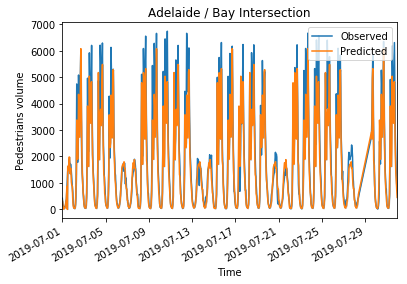

RMSE: 843.3154134794536
R_Squared: 0.38780046021540215


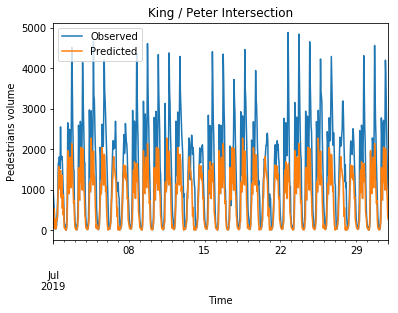

RMSE: 1438.6012561928371
R_Squared: 0.5151480481167157


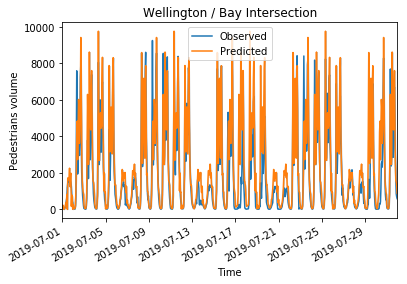

RMSE: 614.4810598435105
R_Squared: 0.39883786921156084


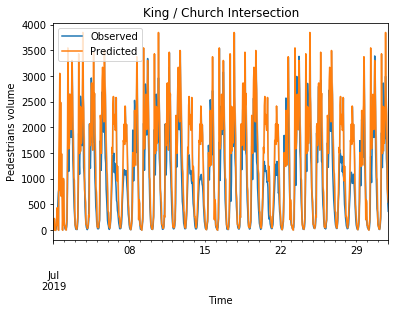

RMSE: 64.90381991895299
R_Squared: -0.001033461056513918


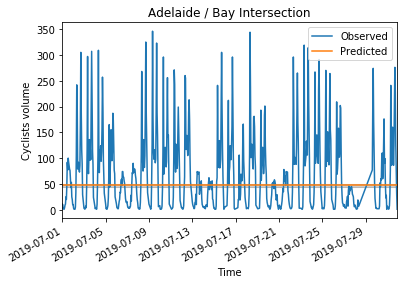

RMSE: 62.28052808947976
R_Squared: -0.01336342766150511


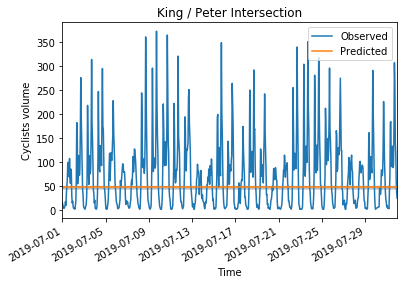

RMSE: 36.99093175709507
R_Squared: -0.883724317667095


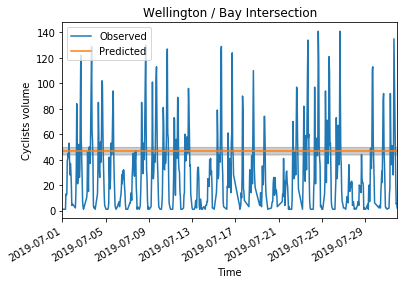

RMSE: 44.4640433773221
R_Squared: -0.042232064497192086


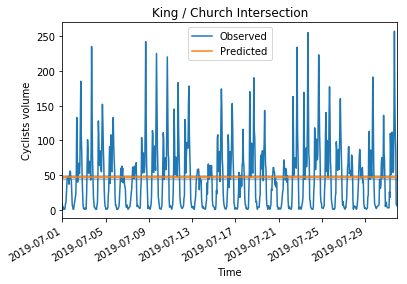

In [4]:
for j in range(2):
    
    gprMdl = gprMdls[j] #Selecting Gaussian process regression model 
    #for pedestrian or cyclists
    
    testData = trafficData[j]
    
    #Validating intersections
    for k in testInts:
        
        testIntersection = testData[k];
        
        IntersectionName = testIntersection['IntName'][0]
        
        #Evaluating the hold-out intersections on the dates for which 
        #the other intersections were trained, i.e., 1 May to 31st may, and 1 July to 31st July
        
        testStart1 = pd.to_datetime('2019-05-01 00:00:00');
        testEnd1 = pd.to_datetime('2019-05-31 23:00:00');
        
        testStart2 = pd.to_datetime('2019-07-01 00:00:00');
        testEnd2 = pd.to_datetime('2019-07-31 23:00:00');
        
        temp1 = testIntersection[testStart1: testEnd1];
        
        temp2 = testIntersection[testStart2: testEnd2];
        
        testIntersection = pd.concat([temp1, temp2])
            
        testIntersection = testIntersection.dropna()
        
        X_test = testIntersection[['Hour','DayOfWeek','isHoliday','lat','lng']]; 
        #These are the most predictive features selected
        
        y_test = testIntersection['volume']
        
        yPred, yStd = gprMdl.predict(X_test, return_std = True)
        yPred = yPred.astype('int'); yPred[yPred<0]=0
        
        yPred = pd.DataFrame(yPred, columns =['forecast']); 
        yPred.index = y_test.index; yPred = yPred['forecast'];      
      
        print('RMSE: '+str(np.sqrt(np.mean((yPred.values - y_test.values)**2))))
        print('R_Squared: '+str(gprMdl.score(X_test, y_test)))
        
        #Plus/minus 3 times the standard deviation is used in order to show the 99.7% confidence bound 
        #of the prediction
        yLow = yPred - 3*yStd; yLow = yLow.astype('int'); yLow[yLow<0]=0
        yHigh = yPred + 3*yStd; yHigh = yHigh.astype('int');

        #Plotting for the month of July only
        testStart = pd.to_datetime('2019-07-01 00:00:00');
        testEnd = pd.to_datetime('2019-07-31 23:00:00');
               
        plt.figure(j+k+1)
        ax = y_test[testStart:testEnd].plot(label = 'Observed')
        yPred[testStart:testEnd].plot(ax = ax, label = 'Predicted')
        ax.fill_between(y_test[testStart:testEnd].index,
                            yLow[testStart:testEnd],
                            yHigh[testStart:testEnd], color='k', alpha=.2)
        ax.set_xlabel('Time')
        ax.set_ylabel(RoadUser[j]+ ' volume')
        ax.set_title(IntersectionName+ ' Intersection')
        plt.legend()
        plt.show()